In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.metrics import r2_score

In [2]:
sns.set(rc={"figure.figsize":(12, 8)})
pd.set_option("display.max_columns", None)

# Import data

In [3]:
data = pd.read_csv('../../tresboncoin/data/master/master_with_fuzzy_and_cleaning.csv')
#data = pd.read_csv('master_with_fuzzy_and_cleaning.csv')
data.drop_duplicates(subset=['model_db', 'brand_db', 'price', 'engine_size_db', 'mileage', 'bike_year'], inplace=True)
#data.drop(columns=['Unnamed: 0'], inplace=True)
data.shape

(29292, 23)

# Feature engineering

## Calculated

In [4]:
def km_per_year(km, bike_year):
    if (datetime.now().year- bike_year) == 0:
        return km
    return km / (datetime.now().year- bike_year)

data['km/year'] = data.apply(lambda x: km_per_year(x['mileage'],x['bike_year']), axis=1)

In [5]:
def age(bike_year):
    return datetime.now().year - bike_year

data['age'] = data.bike_year.apply(age)

In [6]:
data = data[data.engine_size<2000]
data = data[data.engine_size>=49]

# Explore data

In [7]:
data.model.nunique()

5979

In [8]:
data.model_submodel_db.nunique()

2755

## Price
### vs mileage (km) per category

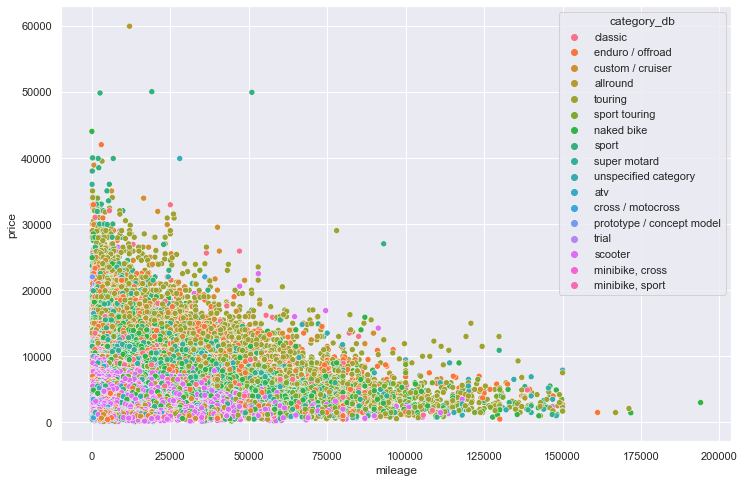

In [9]:
sns.scatterplot(x='mileage', y='price', hue='category_db', data=data);

### vs mileage (km) per engine size

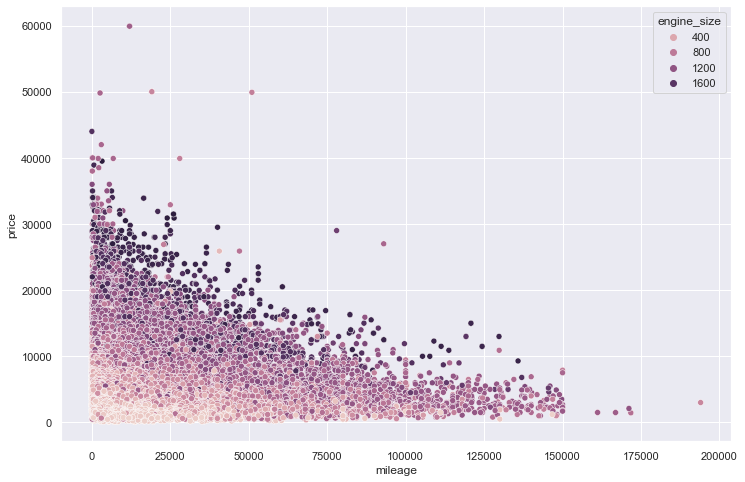

In [10]:
sns.scatterplot(x='mileage', y='price', hue='engine_size', data=data);

### vs mileage (km) per power range

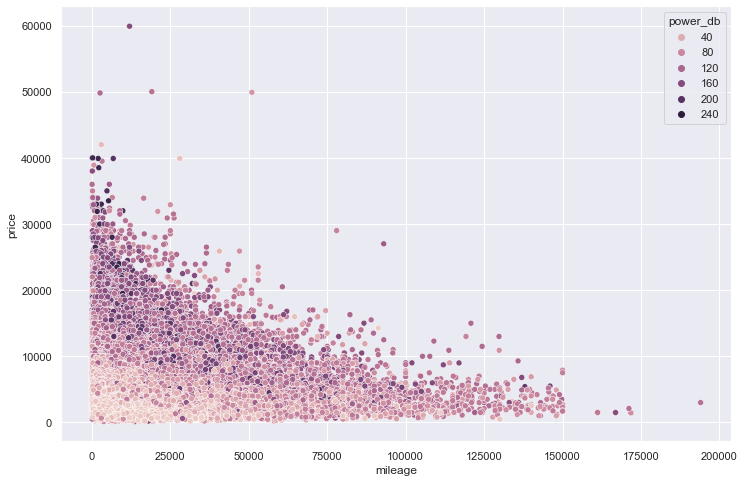

In [11]:
sns.scatterplot(x='mileage', y='price', hue='power_db', data=data);

### vs year of release per category

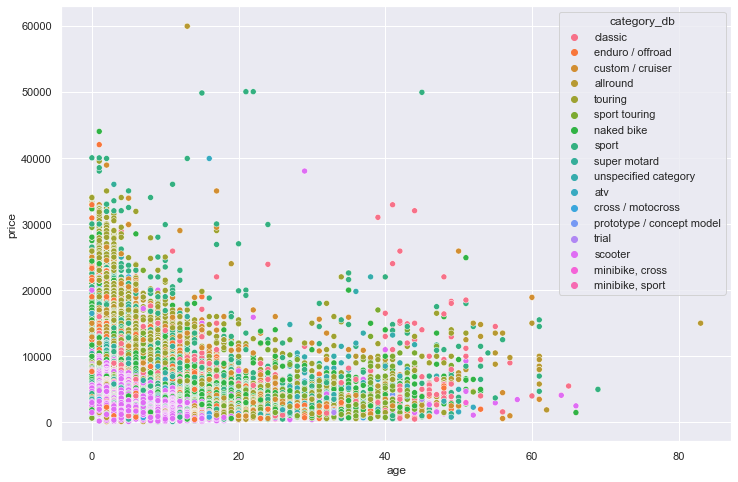

In [12]:
sns.scatterplot(x='age', y='price', hue='category_db',data=data);

### vs year of release per engine size

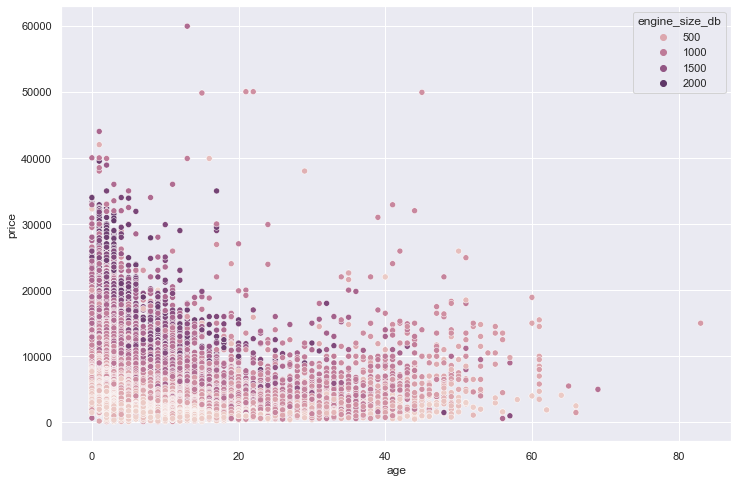

In [13]:
sns.scatterplot(x='age', y='price', hue='engine_size_db', data=data);

### vs km/year

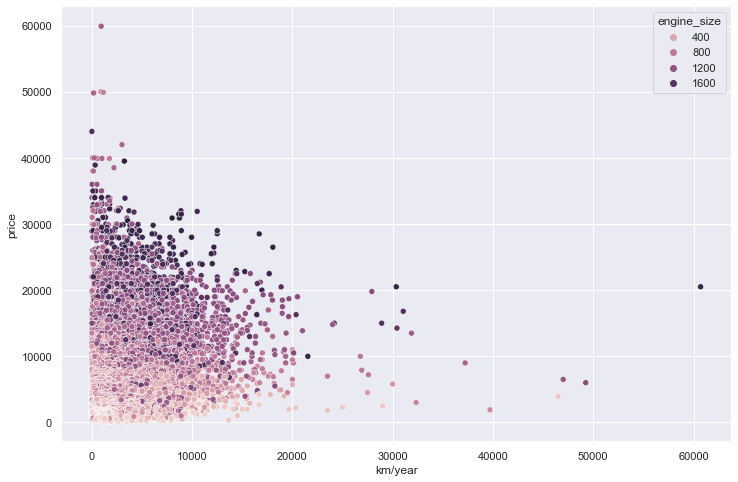

In [14]:
sns.scatterplot(x='km/year', y='price', hue='engine_size',data=data);

### Average price per engine size

In [15]:
data.groupby('engine_size_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
engine_size_db,,,
48.9,7499.000000,NaN,1
49.0,3943.344828,4091.035808,174
49.1,1702.222222,2203.824958,9
49.2,2483.620690,1871.205922,29
49.3,1794.538462,1781.891427,26
...,...,...,...
1890.0,16277.692308,8582.081288,13
1901.0,18536.909091,8800.248911,33
1923.0,25095.000000,11743.992791,4


In [16]:
#engine_size_count_threshold = 3
#groupby_engine_size = data.groupby('engine_size').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#groupby_engine_size[groupby_engine_size.Count < 4]
#groupby_engine_size

### Average price per category

In [17]:
data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
category_db,,,
allround,8123.013527,5325.991840,2070
atv,8448.848837,7149.145677,86
classic,8173.860927,4114.658637,1510
cross / motocross,6665.596491,5000.726336,228
custom / cruiser,8583.878566,6571.470194,1227
enduro / offroad,8975.344095,6235.556909,2354
"minibike, cross",6530.969697,4178.629698,33
"minibike, sport",1770.000000,327.108545,5
naked bike,6905.090449,4416.918523,5528


In [18]:
category_count_threshold = 200
groupby_category = data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_category = groupby_category[groupby_category .Count < category_count_threshold].index.to_list()
drop_category.append('unspecified category')

In [19]:
data = data[data.category_db.isin(drop_category) == False]

### Average price per brand

In [20]:
data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
brand_db,,,
ace,4290.000000,NaN,1
adler,5546.333333,2033.489693,3
adly,11490.000000,NaN,1
alta,22000.000000,NaN,1
aprilia,7869.599099,5380.371266,222
...,...,...,...
xingyue,8108.333333,4892.346915,3
xmotos,2499.000000,NaN,1
yamaha,6969.309626,5048.994989,3501


In [21]:
brand_count_threshold = 100
groupby_brand = data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_brand = groupby_brand[groupby_brand.Count < brand_count_threshold].index.to_list()
data = data[data.brand_db.isin(drop_brand) == False]

### Average price per model

In [22]:
data.groupby(['brand_db','model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

Mean          Std  Count
brand_db model_db                                       
aprilia  atlantic125    10445.000000  5734.635995      2
         atlantic500      896.666667   295.014124      3
         caponord1200    7357.500000  2782.135613      8
         classic125      1300.000000          NaN      1
         dorsoduro1200   8507.222222  4575.631590      9
...                              ...          ...    ...
yamaha   yzfr125         3868.837838  3288.712062     37
         yzfr25          4450.000000   353.553391      2
         yzfr3           4933.800000  1307.439176      5
         yzfr6           5848.687500  2666.531748     16
         yzfr7          49999.000000     0.000000      2

[1830 rows x 3 columns]

In [23]:
#model_count_threshold = 1
#groupby_model = data.groupby(['model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
#data = data[data.model_db.isin(drop_model) == False]

## Correlation matrix

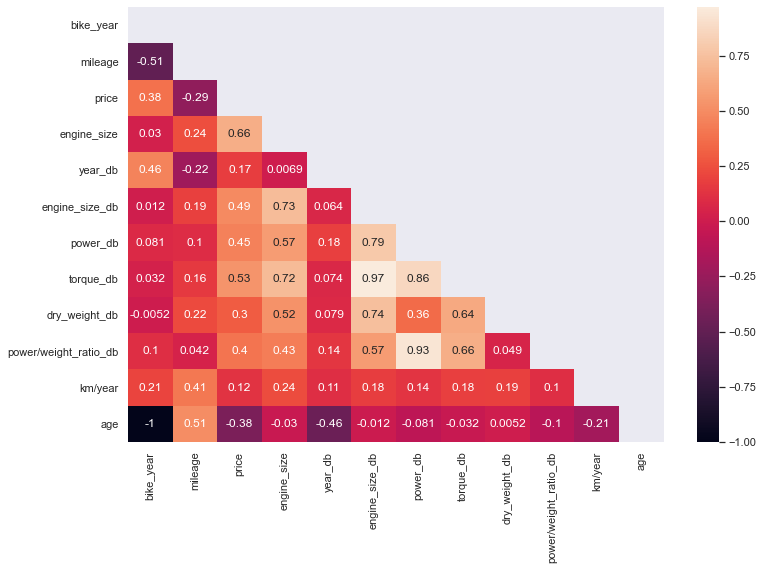

In [24]:
sns.heatmap(data.corr(), annot = True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));

# BASELINE

In [25]:
# mean
average_price = data.price.mean()

#rmse
rmse_baseline = np.sqrt(sum((data['price']-average_price)**2)/((data['price'].count())))

print("Average price :", average_price)
print("RMSE Baseline", rmse_baseline )

Average price : 7702.504757267006
RMSE Baseline 5577.606492949543


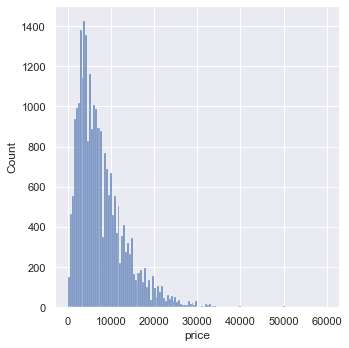

In [26]:
sns.displot(data.price)

# LINEAR REGRESSION

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

## Numerical features (not scaled)

In [28]:
data_1 = data.copy()
data_1.shape

(26696, 25)

In [29]:
features_1 = ['bike_year', 'mileage', 'km/year', 'engine_size']

In [30]:
for feature in features_1:
    data_1.dropna(subset=[feature],inplace=True)
data_1.shape  

(26696, 25)

In [31]:
X = data_1[features_1]
y = data_1['price']

model_1 = LinearRegression()

cv_results = cross_validate(model_1, X, y, cv=5)
cv_results['test_score'].mean()

0.6425138766581006

## Numerical features (not scaled) + brand encoded

In [32]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

model_2 = LinearRegression()

cv_results = cross_validate(model_2, X, y, cv=5)
cv_results['test_score'].mean()

0.6583812646934567

# KNR

## KNeighborsRegressor - Numerical features (not scaled) + brand encoded

In [33]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

In [35]:
model_3 = KNeighborsRegressor(n_neighbors=5)

cv_results = cross_validate(model_3, X, y, cv=3)
cv_results['test_score'].mean()

0.6739891217391945

## KNeighborsRegressor - Numerical features (scaled) + brand encoded

### Brand

### Category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['category_db','brand_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

### Brand and category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

# PIPELINE

In [36]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn import set_config

set_config(display='diagram')

## Pipeline Baseline

### Category

In [37]:
data_1=data.copy()[['age','mileage','engine_size','km/year', 'category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year', 'category_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.788007792855627

### Brand

In [38]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8068648980225002

### Brand & Category

In [39]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db','category_db',]] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8054557134762921

## Pipeline gridsearch

In [ ]:
# Instanciate grid search
grid_search = GridSearchCV(
    final_pipe, 
    param_grid={
        'preprocessing__num_transformer__scaler': [StandardScaler()], #MinMaxScaler(), RobustScaler(), 
        'KNeighborsRegressor__n_neighbors': list(range(9,13)),
        #'KNeighborsRegressor__leaf_size': [1,2,3],
        'KNeighborsRegressor__metric': ['euclidean',
                                        'manhattan'],
        'KNeighborsRegressor__weights': ['uniform', 'distance']},
    cv=3,
    scoring=['r2', 'neg_root_mean_squared_error'],
    refit='r2')

grid_search.fit(X_1, y_1)
print("best_params",grid_search.best_params_)
print("best_score",grid_search.best_score_)

In [ ]:
print(grid_search.score(X_1,y_1))
print(final_pipe_trained.score(X_1,y_1))

In [ ]:
grid_search.cv_results_

## Optimized Pipeline

In [ ]:
num_transformer = Pipeline([('scaler', grid_search.best_params_['preprocessing__num_transformer__scaler'])])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and Regression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor(
        #leaf_size=grid_search.best_params_['KNeighborsRegressor__leaf_size'],
        metric=grid_search.best_params_['KNeighborsRegressor__metric'], 
        n_neighbors=grid_search.best_params_['KNeighborsRegressor__n_neighbors'], 
        weights=grid_search.best_params_['KNeighborsRegressor__weights']))])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(final_pipe, X_1, y_1, cv=3, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

## Prediction

In [ ]:
X_pred = pd.DataFrame([[10,5000,800,1000,'bmw']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])

In [ ]:
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[4,2347,1200,586,'triumph']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[6,26500,990,4416,'ktm']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )